# FloPy

### ZoneBudget Example

This notebook demonstrates how to use the `ZoneBudget` class to extract budget information from the cell by cell budget file using an array of zones.

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.5.3 |Continuum Analytics, Inc.| (default, Feb 22 2017, 21:28:42) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.11.3
matplotlib version: 2.0.0
pandas version: 0.19.2
flopy version: 3.2.7


In [2]:
# Set path to example datafiles
loadpth = os.path.join('..', 'data', 'zonbud_examples')
cbc_f = os.path.join(loadpth, 'freyberg_mlt', 'freyberg.gitcbc')

### Read File Containing Zones
Using the `read_zbarray` utility, we can import zonebudget-style array files.

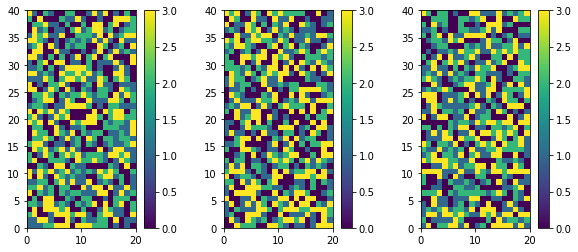

array([0, 1, 2, 3], dtype=int64)

In [3]:
from flopy.utils import read_zbarray

zone_file = os.path.join(loadpth, 'zonef_mlt')
zon = read_zbarray(zone_file)
nlay, nrow, ncol = zon.shape

fig = plt.figure(figsize=(10, 4))

for lay in range(nlay):
    ax = fig.add_subplot(1, nlay, lay+1)
    im = ax.pcolormesh(zon[lay, :, :])
    cbar = plt.colorbar(im)
    plt.gca().set_aspect('equal')
    
plt.show()
np.unique(zon)

### Extract Budget Information from ZoneBudget Object

At the core of the `ZoneBudget` object is a numpy structured array. The class provides some wrapper functions to help us interogate the array and save it to disk.

In [4]:
# Create a ZoneBudget object and get the budget record array
zb = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=(0, 1096))
zb.get_budget()

array([(1097.0, 0, 1096, 'STORAGE_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'CONSTANT_HEAD_IN', 0.0, 0.0, 86.14904022216797),
       (1097.0, 0, 1096, 'WELLS_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'DRAINS_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'RECHARGE_IN', 1306.9328665733337, 1299.4646787643433, 1277.0601153373718),
       (1097.0, 0, 1096, 'ZONE_0_IN', 4802.644836425781, 3535.9047956466675, 3882.708930850029),
       (1097.0, 0, 1096, 'ZONE_1_IN', 0.0, 3485.947250366211, 3202.0619506835938),
       (1097.0, 0, 1096, 'ZONE_2_IN', 3823.0936737060547, 0.0, 2978.4641098976135),
       (1097.0, 0, 1096, 'ZONE_3_IN', 3579.748610496521, 3084.417018890381, 0.0),
       (1097.0, 0, 1096, 'TOTAL_IN', 13512.41998720169, 11405.733743667603, 11426.444146990776),
       (1097.0, 0, 1096, 'STORAGE_OUT', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'CONSTANT_HEAD_OUT', 101.54193305969238, 232.463134765625, 204.33761596679688),
       (1097.0, 0, 1096, 'WELLS_OUT', 2656.7999267578125, 

In [5]:
# Get a list of the unique budget record names
zb.get_record_names()

array(['CONSTANT_HEAD_IN', 'CONSTANT_HEAD_OUT', 'DRAINS_IN', 'DRAINS_OUT',
       'IN-OUT', 'PERCENT_DISCREPANCY', 'RECHARGE_IN', 'RECHARGE_OUT',
       'STORAGE_IN', 'STORAGE_OUT', 'TOTAL_IN', 'TOTAL_OUT', 'WELLS_IN',
       'WELLS_OUT', 'ZONE_0_IN', 'ZONE_0_OUT', 'ZONE_1_IN', 'ZONE_1_OUT',
       'ZONE_2_IN', 'ZONE_2_OUT', 'ZONE_3_IN', 'ZONE_3_OUT'], 
      dtype='<U50')

In [6]:
# Look at a subset of fluxes
names = ['RECHARGE_IN', 'ZONE_1_IN', 'ZONE_3_IN']
zb.get_budget(names=names)

array([ (1097.0, 0, 1096, 'RECHARGE_IN', 1306.9328665733337, 1299.4646787643433, 1277.0601153373718),
       (1097.0, 0, 1096, 'ZONE_1_IN', 0.0, 3485.947250366211, 3202.0619506835938),
       (1097.0, 0, 1096, 'ZONE_3_IN', 3579.748610496521, 3084.417018890381, 0.0)], 
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('name', '<U50'), ('ZONE_1', '<f8'), ('ZONE_2', '<f8'), ('ZONE_3', '<f8')])

In [7]:
# Look at fluxes in from zone 2
names = ['RECHARGE_IN', 'ZONE_1_IN', 'ZONE_3_IN']
zones = ['ZONE_2']
zb.get_budget(names=names, zones=zones)

array([(1097.0, 0, 1096, 'RECHARGE_IN', 1299.4646787643433),
       (1097.0, 0, 1096, 'ZONE_1_IN', 3485.947250366211),
       (1097.0, 0, 1096, 'ZONE_3_IN', 3084.417018890381)], 
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('name', '<U50'), ('ZONE_2', '<f8')])

In [8]:
# Look at all of the mass-balance records
names = ['TOTAL_IN', 'TOTAL_OUT', 'IN-OUT', 'PERCENT_DISCREPANCY']
zb.get_budget(names=names)

array([ (1097.0, 0, 1096, 'TOTAL_IN', 13512.41998720169, 11405.733743667603, 11426.444146990776),
       (1097.0, 0, 1096, 'TOTAL_OUT', 13512.432970046997, 11405.73255777359, 11426.435069084167)], 
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('name', '<U50'), ('ZONE_1', '<f8'), ('ZONE_2', '<f8'), ('ZONE_3', '<f8')])

### Convert Units
The `ZoneBudget` class supports the use of mathematical operators and returns a new copy of the object.

In [9]:
cmd = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=(0, 0))
cfd = cmd / 35.3147
inyr = (cfd / (250 * 250)) * 365 * 12

cmdbud = cmd.get_budget()
cfdbud = cfd.get_budget()
inyrbud = inyr.get_budget()

names = ['RECHARGE_IN']
rowidx = np.in1d(cmdbud['name'], names)
colidx = 'ZONE_1'

print('{:,.1f} cubic meters/day'.format(cmdbud[rowidx][colidx][0]))
print('{:,.1f} cubic feet/day'.format(cfdbud[rowidx][colidx][0]))
print('{:,.1f} inches/year'.format(inyrbud[rowidx][colidx][0]))

1,580.5 cubic meters/day
44.8 cubic feet/day
3.1 inches/year


In [10]:
cmd is cfd

False

### Alias Names
A dictionary of {zone: "alias"} pairs can be passed to replace the typical "ZONE_X" fieldnames of the `ZoneBudget` structured array with more descriptive names.

In [11]:
aliases = {1: 'SURF', 2:'CONF', 3: 'UFA'}
zb = flopy.utils.ZoneBudget(cbc_f, zon, totim=[1097.], aliases=aliases)
zb.get_budget()

array([(1097.0, 0, 1096, 'STORAGE_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'CONSTANT_HEAD_IN', 0.0, 0.0, 86.14904022216797),
       (1097.0, 0, 1096, 'WELLS_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'DRAINS_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'RECHARGE_IN', 1306.9328665733337, 1299.4646787643433, 1277.0601153373718),
       (1097.0, 0, 1096, 'ZONE_0_IN', 4802.644836425781, 3535.9047956466675, 3882.708930850029),
       (1097.0, 0, 1096, 'SURF_IN', 0.0, 3485.947250366211, 3202.0619506835938),
       (1097.0, 0, 1096, 'CONF_IN', 3823.0936737060547, 0.0, 2978.4641098976135),
       (1097.0, 0, 1096, 'UFA_IN', 3579.748610496521, 3084.417018890381, 0.0),
       (1097.0, 0, 1096, 'TOTAL_IN', 13512.41998720169, 11405.733743667603, 11426.444146990776),
       (1097.0, 0, 1096, 'STORAGE_OUT', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'CONSTANT_HEAD_OUT', 101.54193305969238, 232.463134765625, 204.33761596679688),
       (1097.0, 0, 1096, 'WELLS_OUT', 2656.7999267578125, 0.0, 0.

### Return the Budgets as a Pandas DataFrame
Set `kstpkper` and `totim` keyword args to `None` (or omit) to return all times.
The `get_dataframes()` method will return a DataFrame multi-indexed on `totim` and `name`.

In [12]:
zon = np.ones((nlay, nrow, ncol), np.int)
zon[1, :, :] = 2
zon[2, :, :] = 3

aliases = {1: 'SURF', 2:'CONF', 3: 'UFA'}
zb = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=None, totim=None, aliases=aliases)
df = zb.get_dataframes()
print(df.head())
print(df.tail())

                                SURF        CONF          UFA
totim name                                                   
1.0   CONF_IN            2218.183105    0.000000  1863.491943
      CONF_OUT           3752.850586    0.000000  1096.248657
      CONSTANT_HEAD_IN      0.000000    0.000000     0.000000
      CONSTANT_HEAD_OUT   911.639771  767.433716   767.249390
      DRAINS_IN             0.000000    0.000000     0.000000
                         SURF         CONF          UFA
totim  name                                            
1097.0 TOTAL_OUT  8328.821304  4869.630325  1725.220764
       UFA_IN        0.000000  1487.757812     0.000000
       UFA_OUT       0.000000  1639.001221     0.000000
       WELLS_IN      0.000000     0.000000     0.000000
       WELLS_OUT  4762.799942     0.000000     0.000000


Slice the multi-index dataframe to retrieve a subset of the budget.
NOTE: We can now pass "names" directly to the `get_dataframes()` method to return a subset of reocrds. By omitting the `"_IN"` or `"_OUT"` suffix we get both.

In [13]:
dateidx1 = 1092.
dateidx2 = 1097.
names = ['RECHARGE_IN', 'WELLS_OUT', 'CONSTANT_HEAD']
zones = ['SURF', 'CONF']
df = zb.get_dataframes(names=names)
df.loc[(slice(dateidx1, dateidx2), slice(None)), :][zones]

SURF        CONF
totim  name                                      
1092.0 CONSTANT_HEAD_IN      8.232683    4.993078
       CONSTANT_HEAD_OUT   717.869995  608.265503
       RECHARGE_IN        6070.894356    0.000000
       WELLS_OUT          2829.812140    0.000000
1093.0 CONSTANT_HEAD_IN     10.557623    6.348190
       CONSTANT_HEAD_OUT   708.597717  600.514709
       RECHARGE_IN        4240.286350    0.000000
       WELLS_OUT          1930.483119    0.000000
1094.0 CONSTANT_HEAD_IN     11.797873    7.080081
       CONSTANT_HEAD_OUT   702.379089  595.157471
       RECHARGE_IN        4082.749522    0.000000
       WELLS_OUT          1279.166363    0.000000
1095.0 CONSTANT_HEAD_IN      9.060410    5.471514
       CONSTANT_HEAD_OUT   717.303589  607.924377
       RECHARGE_IN        5053.779073    0.000000
       WELLS_OUT           794.582903    0.000000
1096.0 CONSTANT_HEAD_IN      4.007133    2.494755
       CONSTANT_HEAD_OUT   744.257141  631.000854
       RECHARGE_IN        6168.920364    0.000000
       WELLS_OUT          1373.782646    0.000000
1097.0 CONSTANT_HEAD_IN    145.417542   86.149040
       CONSTANT_HEAD_OUT   270.298218  237.602493
       RECHARGE_IN        5190.390527    0.000000
       WELLS_OUT          4762.799942    0.000000

Look at pumpage (`WELLS_OUT`) as a percentage of recharge (`RECHARGE_IN`)

In [14]:
dateidx1 = 1092.
dateidx2 = 1097.
zones = ['SURF']

# Pull out the individual records of interest
rech = df.loc[(slice(dateidx1, dateidx2), ['RECHARGE_IN']), :][zones]
pump = df.loc[(slice(dateidx1, dateidx2), ['WELLS_OUT']), :][zones]

# Remove the "record" field from the index so we can 
# take the difference of the two DataFrames
rech = rech.reset_index()
rech = rech.set_index(['totim'])
rech = rech[zones]
pump = pump.reset_index()
pump = pump.set_index(['totim'])
pump = pump[zones] * -1

# Compute pumping as a percentage of recharge
pump_as_pct = (pump / rech) * 100.
pump_as_pct

,SURF
totim,
1092.0,-46.612772
1093.0,-45.527188
1094.0,-31.331003
1095.0,-15.722549
1096.0,-22.269418
1097.0,-91.761880


Pass `start_datetime` and `timeunit` keyword arguments to return a dataframe with a datetime multi-index

In [15]:
dateidx1 = pd.Timestamp('1972-12-01')
dateidx2 = pd.Timestamp('1972-12-06')
names = ['RECHARGE_IN', 'WELLS_OUT', 'CONSTANT_HEAD']
zones = ['SURF', 'CONF']
df = zb.get_dataframes(start_datetime='1970-01-01', timeunit='D', names=names)
df.loc[(slice(dateidx1, dateidx2), slice(None)), :][zones]

SURF        CONF
datetime   name                                      
1972-12-01 CONSTANT_HEAD_IN      0.000000    0.000000
           CONSTANT_HEAD_OUT   845.552979  717.054688
           RECHARGE_IN        8331.025639    0.000000
           WELLS_OUT          5903.374154    0.000000
1972-12-02 CONSTANT_HEAD_IN      0.000000    0.000000
           CONSTANT_HEAD_OUT   848.445923  719.648071
           RECHARGE_IN        7553.003516    0.000000
           WELLS_OUT          1705.206116    0.000000
1972-12-03 CONSTANT_HEAD_IN      0.000000    0.000000
           CONSTANT_HEAD_OUT   835.000916  708.997253
           RECHARGE_IN        5630.780802    0.000000
           WELLS_OUT          2157.596333    0.000000
1972-12-04 CONSTANT_HEAD_IN      0.000000    0.000000
           CONSTANT_HEAD_OUT   831.632568  706.147217
           RECHARGE_IN        6026.509709    0.000000
           WELLS_OUT          5252.826000    0.000000
1972-12-05 CONSTANT_HEAD_IN      0.000000    0.000000
           CONSTANT_HEAD_OUT   847.015320  718.418274
           RECHARGE_IN        7979.104075    0.000000
           WELLS_OUT          6158.951546    0.000000
1972-12-06 CONSTANT_HEAD_IN      0.000000    0.000000
           CONSTANT_HEAD_OUT   855.501160  725.291626
           RECHARGE_IN        8254.627576    0.000000
           WELLS_OUT          2989.254021    0.000000

Pass `index_key` to indicate which fields to use in the multi-index (defualt is "totim"; valid keys are "totim" and "kstpkper")

In [16]:
df = zb.get_dataframes(index_key='kstpkper')
df.head()

SURF        CONF  \
time_step stress_period name                                         
0         0             CONF_IN            2218.183105    0.000000   
                        CONF_OUT           3752.850586    0.000000   
                        CONSTANT_HEAD_IN      0.000000    0.000000   
                        CONSTANT_HEAD_OUT   911.639771  767.433716   
                        DRAINS_IN             0.000000    0.000000   

                                                   UFA  
time_step stress_period name                            
0         0             CONF_IN            1863.491943  
                        CONF_OUT           1096.248657  
                        CONSTANT_HEAD_IN      0.000000  
                        CONSTANT_HEAD_OUT   767.249390  
                        DRAINS_IN             0.000000

### Write Budget Output to CSV

We can write the resulting recarray to a csv file with the `.to_csv()` method of the `ZoneBudget` object.

In [17]:
zb = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=[(0, 0), (0, 1096)])
zb.to_csv(os.path.join(loadpth, 'zonbud.csv'))

# Read the file in to see the contents
fname = os.path.join(loadpth, 'zonbud.csv')
try:
    import pandas as pd
    print(pd.read_csv(fname).to_string(index=False))
except:
    with open(fname, 'r') as f:
        for line in f.readlines():
            print('\t'.join(line.split(',')))

totim  time_step  stress_period                 name       ZONE_1       ZONE_2       ZONE_3
   1.0          0              0           STORAGE_IN     0.000000     0.000000     0.000000
   1.0          0              0     CONSTANT_HEAD_IN     0.000000     0.000000     0.000000
   1.0          0              0             WELLS_IN     0.000000     0.000000     0.000000
   1.0          0              0            DRAINS_IN     0.000000     0.000000     0.000000
   1.0          0              0          RECHARGE_IN  6276.861916     0.000000     0.000000
   1.0          0              0            ZONE_1_IN     0.000000  3752.850586     0.000000
   1.0          0              0            ZONE_2_IN  2218.183105     0.000000  1863.491943
   1.0          0              0            ZONE_3_IN     0.000000  1096.248657     0.000000
   1.0          0              0             TOTAL_IN  8495.045021  4849.099243  1863.491943
   1.0          0              0          STORAGE_OUT     0.000000     

### Net Budget
Using the "net" keyword argument, we can request a net budget for each zone/record name or for a subset of zones and record names. Note that we can identify the record names we want without the added `"_IN"` or `"_OUT"` string suffix.

In [18]:
zon = np.ones((nlay, nrow, ncol), np.int)
zon[1, :, :] = 2
zon[2, :, :] = 3

aliases = {1: 'SURF', 2:'CONF', 3: 'UFA'}
zb = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=None, totim=None, aliases=aliases)
cfd = zb.get_budget(names=['STORAGE', 'WELLS'], zones=['SURF', 'UFA'], net=True)
cfd

array([(1.0, 0, 0, 'STORAGE', 0.0, 0.0), (1.0, 0, 0, 'WELLS', 0.0, 0.0),
       (2.0, 0, 1, 'STORAGE', 219.27908273598587, 192.47897395201653), ...,
       (1096.0, 0, 1095, 'WELLS', -1373.7826461791992, 0.0),
       (1097.0, 0, 1096, 'STORAGE', 0.0, 0.0),
       (1097.0, 0, 1096, 'WELLS', -4762.799942016602, 0.0)], 
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('name', '<U50'), ('SURF', '<f8'), ('UFA', '<f8')])

In [19]:
df = zb.get_dataframes(names=['STORAGE', 'WELLS'], zones=['SURF', 'UFA'], net=True)
df.head(6)

SURF         UFA
totim name                            
1.0   STORAGE     0.000000    0.000000
      WELLS       0.000000    0.000000
2.0   STORAGE   219.279083  192.478974
      WELLS   -1302.403252    0.000000
3.0   STORAGE   575.833970  386.666232
      WELLS   -1618.676394    0.000000

## Plot Budget Components
The following is a function that can be used to better visualize the budget components using matplotlib.

In [20]:
def tick_label_formatter_comma_sep(x, pos):
    return '{:,.0f}'.format(x)


def volumetric_budget_bar_plot(values_in, values_out, labels, **kwargs):
    if 'ax' in kwargs:
        ax = kwargs.pop('ax')
    else:
        ax = plt.gca()

    x_pos = np.arange(len(values_in))
    rects_in = ax.bar(x_pos, values_in, align='center', alpha=0.5)

    x_pos = np.arange(len(values_out))
    rects_out = ax.bar(x_pos, values_out, align='center', alpha=0.5)

    plt.xticks(list(x_pos), labels)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(tick_label_formatter_comma_sep))

    ymin, ymax = ax.get_ylim()
    if ymax != 0:
        if abs(ymin) / ymax < .33:
            ymin = -(ymax * .5)
        else:
            ymin *= 1.35
    else:
        ymin *= 1.35
    plt.ylim([ymin, ymax * 1.25])

    for i, rect in enumerate(rects_in):
        label = '{:,.0f}'.format(values_in[i])
        height = values_in[i]
        x = rect.get_x() + rect.get_width() / 2
        y = height + (.02 * ymax)
        vertical_alignment = 'bottom'
        horizontal_alignment = 'center'
        ax.text(x, y, label, ha=horizontal_alignment, va=vertical_alignment, rotation=90)

    for i, rect in enumerate(rects_out):
        label = '{:,.0f}'.format(values_out[i])
        height = values_out[i]
        x = rect.get_x() + rect.get_width() / 2
        y = height + (.02 * ymin)
        vertical_alignment = 'top'
        horizontal_alignment = 'center'
        ax.text(x, y, label, ha=horizontal_alignment, va=vertical_alignment, rotation=90)

    # horizontal line indicating zero
    ax.plot([rects_in[0].get_x() - rects_in[0].get_width() / 2,
             rects_in[-1].get_x() + rects_in[-1].get_width()], [0, 0], "k")

    return rects_in, rects_out

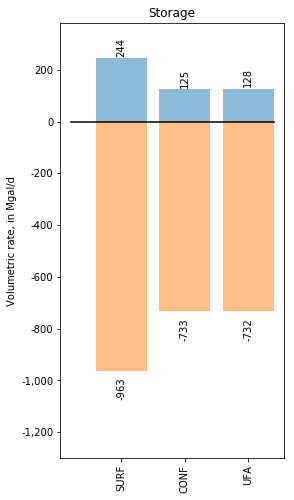

In [21]:
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot(111)

zb = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=None, totim=[1095.], aliases=aliases)

recname = 'STORAGE'
values_in = zb.get_dataframes(names='{}_IN'.format(recname)).T.squeeze()
values_out = zb.get_dataframes(names='{}_OUT'.format(recname)).T.squeeze() * -1
labels = values_in.index.tolist()

rects_in, rects_out = volumetric_budget_bar_plot(values_in, values_out, labels, ax=ax)

plt.ylabel('Volumetric rate, in Mgal/d')
plt.title(recname.title())
plt.show()